In [1]:
import os
import json

# Load the kaggle.json file and move it to the correct location
with open('/kaggle/input/kkkeyindoor/kaggle.json') as f:
    kaggle_creds = json.load(f)

os.makedirs('/root/.kaggle/', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_creds, f)

# Set the permissions
os.chmod('/root/.kaggle/kaggle.json', 600)

In [2]:
!kaggle datasets download -d itsahmad/indoor-scenes-cvpr-2019

 99%|██████████████████████████████████████▋| 2.32G/2.34G [00:14<00:00, 186MB/s]
100%|███████████████████████████████████████| 2.34G/2.34G [00:14<00:00, 172MB/s]


In [3]:
# Unzip the downloaded dataset
import zipfile
with zipfile.ZipFile('/kaggle/working/indoor-scenes-cvpr-2019.zip', 'r') as zip_ref:
    zip_ref.extractall('indoor-scenes-cvpr-2019')

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import layers, models
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from tensorflow.keras import backend as K
# Clear session
K.clear_session()

In [6]:
from glob import glob
import random
import shutil

In [7]:
# Define paths
base_dir = '/kaggle/working/indoor-scenes-cvpr-2019/indoorCVPR_09/Images'
train_dir = '/kaggle/working/indoor-scenes-cvpr-2019/indoorCVPR_09/train'
validation_dir = '/kaggle/working/indoor-scenes-cvpr-2019/indoorCVPR_09/validation'
test_dir = '/kaggle/working/indoor-scenes-cvpr-2019/indoorCVPR_09/test'

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to split data
def split_data(source_dir, train_dir, validation_dir, test_dir, train_split=0.7, validation_split=0.2):
    breeds = os.listdir(source_dir)
    for breed in breeds:
        breed_path = os.path.join(source_dir, breed)
        images = glob(os.path.join(breed_path, '*.jpg'))
        random.shuffle(images)
        train_size = int(train_split * len(images))
        validation_size = int(validation_split * len(images))

        train_images = images[:train_size]
        validation_images = images[train_size:train_size + validation_size]
        test_images = images[train_size + validation_size:]

        breed_train_dir = os.path.join(train_dir, breed)
        breed_validation_dir = os.path.join(validation_dir, breed)
        breed_test_dir = os.path.join(test_dir, breed)

        os.makedirs(breed_train_dir, exist_ok=True)
        os.makedirs(breed_validation_dir, exist_ok=True)
        os.makedirs(breed_test_dir, exist_ok=True)

        for image in train_images:
            shutil.copy(image, breed_train_dir)

        for image in validation_images:
            shutil.copy(image, breed_validation_dir)

        for image in test_images:
            shutil.copy(image, breed_test_dir)

# Split the data
split_data(base_dir, train_dir, validation_dir, test_dir)


In [8]:
root = '/kaggle/working/indoor-scenes-cvpr-2019/indoorCVPR_09/Images'
img_width = 128
img_height = 128
batch_size = 64
nb_epochs = 50

In [9]:
train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
# Only rescaling for validation and test sets
validation_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10900 images belonging to 67 classes.


In [11]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3098 images belonging to 67 classes.
Found 1615 images belonging to 67 classes.


In [12]:
# model= tf.keras.models.load_model('/kaggle/input/efficientnetv1-b7-noisy-student/efficientnetv1-b7-noisy_student.h5')
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

16705208/16705208 [==============================] - 0s 0us/step


In [13]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [15]:
# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [16]:
num_layers = len(model.layers)
num_layers

242

In [17]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 128, 128, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 128, 128, 3)          0         ['normalization[0][0]']   

In [18]:
import keras
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler


checkpoint = ModelCheckpoint("best_model_weights.h5", 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,
                               restore_best_weights=True)

def lr_schedule(epoch):
    initial_lr = 0.001 
    decay_factor = 0.5 
    decay_epochs = 4  

    learning_rate = initial_lr * (decay_factor ** (epoch // decay_epochs))

    return learning_rate

lr_scheduler = LearningRateScheduler(lr_schedule)

In [19]:
model.compile(Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [20]:
his= model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[checkpoint,early_stopping,lr_scheduler] 
    )

Epoch 1/50


2024-06-19 17:53:59.046640: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


170/170 [==============================] - ETA: 0s - loss: 5.3564 - accuracy: 0.4929
Epoch 1: val_accuracy improved from -inf to 0.60905, saving model to best_model_weights.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


170/170 [==============================] - 65s 329ms/step - loss: 5.3564 - accuracy: 0.4929 - val_loss: 2.4767 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 2/50
170/170 [==============================] - ETA: 0s - loss: 2.3545 - accuracy: 0.6033
Epoch 2: val_accuracy improved from 0.60905 to 0.61556, saving model to best_model_weights.h5
170/170 [==============================] - 52s 309ms/step - loss: 2.3545 - accuracy: 0.6033 - val_loss: 2.1728 - val_accuracy: 0.6156 - lr: 0.0010
Epoch 3/50
170/170 [==============================] - ETA: 0s - loss: 2.2181 - accuracy: 0.6125
Epoch 3: val_accuracy improved from 0.61556 to 0.63314, saving model to best_model_weights.h5
170/170 [==============================] - 53s 314ms/step - loss: 2.2181 - accuracy: 0.6125 - val_loss: 2.0914 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 4/50
170/170 [==============================] - ETA: 0s - loss: 2.1874 - accuracy: 0.6180
Epoch 4: val_accuracy did not improve from 0.63314
170/170 [=======================

In [21]:
loss, accuracy = model.evaluate(validation_generator)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

49/49 [==============================] - 13s 255ms/step - loss: 1.4598 - accuracy: 0.6908
Validation loss: 1.4598228931427002
Validation accuracy: 0.6907682418823242


In [22]:
loss, accuracy = model.evaluate(test_generator)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

26/26 [==============================] - 7s 272ms/step - loss: 1.4704 - accuracy: 0.6793
Test loss: 1.4704421758651733
Test accuracy: 0.6792569756507874


In [23]:
import matplotlib.pyplot as plt


def plot_hist(his):
    plt.plot(his.history["accuracy"])
    plt.plot(his.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

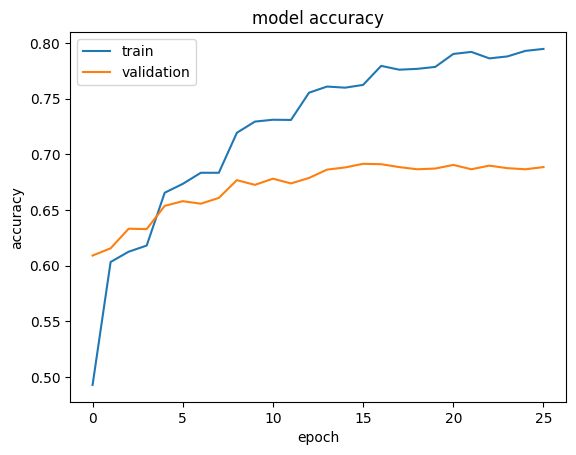

In [24]:
plot_hist(his)

In [25]:
model.save('EfficientNetB0_model_IndoorGames.h5')

In [26]:
with open('EfficientNetB0_model_IndoorGamesclass_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

In [27]:
from IPython.display import FileLink
FileLink('EfficientNetB0_model_IndoorGames.h5')

/kaggle/working/EfficientNetB0_model_IndoorGames.h5

In [28]:
FileLink('EfficientNetB0_model_IndoorGamesclass_indices.json')

/kaggle/working/EfficientNetB0_model_IndoorGamesclass_indices.json

In [29]:
from sklearn.metrics import precision_score, recall_score, classification_report
import numpy as np
# Function to calculate precision and recall
def calculate_metrics(model, generator):
    # Get true labels and predictions
    y_true = []
    y_pred = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(model.predict(x_batch), axis=1))
    
    # Calculate precision and recall
    precision = precision_score(y_true, y_pred, average=None)  # Per-class precision
    recall = recall_score(y_true, y_pred, average=None)  # Per-class recall
    report = classification_report(y_true, y_pred, target_names=generator.class_indices.keys())
    
    return precision, recall, report




In [30]:
# Calculate precision and recall on training data
train_precision, train_recall, train_report = calculate_metrics(model, train_generator)
print("Training Precision: ", train_precision)
print("Training Recall: ", train_recall)
print("Training Classification Report: \n", train_report)

1/1 [==============================] - 2s 2s/step
Training Precision:  [0.78825996 0.72641509 0.79166667 0.7388724  0.78348214 0.8984375
 0.82688391 0.74074074 0.98601399 0.94285714 0.93188011 0.81355932
 0.92366412 0.82432432 0.94252874 0.9787234  0.91044776 0.94117647
 0.890625   0.864      0.75396825 0.98734177 0.70731707 0.94366197
 0.8245614  0.97260274 0.84146341 0.98076923 0.98571429 0.85314685
 0.93209877 0.72361809 0.84313725 1.         0.93393393 0.76666667
 0.77894737 0.78510998 0.7625     0.98816568 0.76056338 0.72445255
 0.77966102 0.85227273 0.83928571 0.86363636 0.85       0.8313253
 0.95505618 0.84210526 0.8        0.89090909 0.97478992 0.93220339
 0.75128205 0.7972973  0.80882353 0.94594595 0.88059701 0.89501312
 0.79831933 0.91208791 0.83760684 0.84745763 0.79166667 0.87978142
 0.94594595]
Training Recall:  [0.88470588 0.78571429 0.77235772 0.87985866 0.83175355 0.83941606
 0.87688985 0.82706767 0.94630872 0.85714286 0.95       0.61538462
 0.968      0.7721519  0.9761

In [31]:
# Calculate precision and recall on validation data
val_precision, val_recall, val_report = calculate_metrics(model, validation_generator)
print("Validation Precision: ", val_precision)
print("Validation Recall: ", val_recall)
print("Validation Classification Report: \n", val_report)

1/1 [==============================] - 0s 28ms/step
Validation Precision:  [0.5483871  0.54545455 0.60714286 0.61818182 0.65925926 0.72727273
 0.68666667 0.61052632 0.85       0.6875     0.9009901  0.54545455
 0.63043478 0.75       0.84615385 0.78787879 0.86666667 0.68
 0.54166667 0.71641791 0.38235294 0.8125     0.53846154 0.58333333
 0.6        0.85714286 0.86363636 0.73333333 0.9047619  0.75609756
 0.88888889 0.79166667 0.75       0.93333333 0.86956522 0.53846154
 0.5        0.69364162 0.55       0.7755102  0.5        0.51923077
 0.5        0.62       0.56666667 0.65909091 0.8        0.38095238
 0.89285714 0.63636364 0.51428571 0.84415584 0.90322581 0.82352941
 0.6        0.64       0.5625     0.75757576 0.66666667 0.76576577
 0.72307692 0.95       0.7        0.64705882 0.66666667 0.77083333
 0.81818182]
Validation Recall:  [0.70247934 0.64285714 0.48571429 0.83950617 0.74166667 0.61538462
 0.78030303 0.76315789 0.80952381 0.5        0.88349515 0.27272727
 0.80555556 0.68181818 0.91

In [32]:
# Calculate precision and recall on test data
test_precision, test_recall, test_report = calculate_metrics(model, test_generator)
print("Validation Precision: ", test_precision)
print("Validation Recall: ", test_recall)
print("Validation Classification Report: \n", test_report)

1/1 [==============================] - 0s 27ms/step
Validation Precision:  [0.56043956 0.38888889 0.63157895 0.51612903 0.578125   0.88235294
 0.75362319 0.58       0.82608696 0.78571429 0.83333333 0.6
 0.80952381 0.7        0.85714286 0.85714286 0.55555556 0.8
 0.6        0.70731707 0.38461538 0.8        0.66666667 0.88888889
 1.         1.         0.8        0.85714286 1.         0.8
 0.85714286 0.57142857 0.83333333 0.81818182 0.84313725 0.6
 0.53333333 0.66666667 0.27777778 0.84       0.6        0.5308642
 0.23076923 0.5862069  0.53333333 0.85       0.65217391 0.72727273
 0.66666667 0.5        0.46666667 0.7804878  0.93333333 0.88888889
 0.66666667 0.625      0.6        0.78571429 0.85714286 0.78846154
 0.53658537 0.9        0.90909091 0.625      0.72727273 0.66666667
 0.79166667]
Validation Recall:  [0.82258065 0.5        0.66666667 0.7804878  0.59677419 0.71428571
 0.7761194  0.76315789 0.86363636 0.91666667 0.86538462 0.25
 0.89473684 0.58333333 1.         0.85714286 0.45454545 

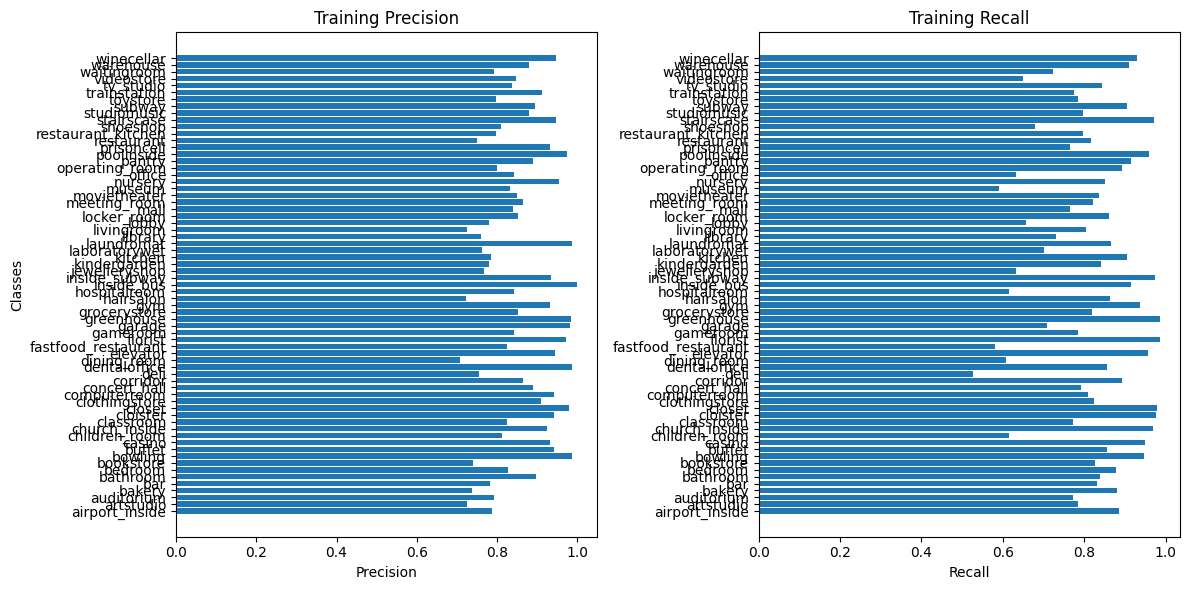

In [33]:
# Plot precision and recall for training data
plt.figure(figsize=(12, 6))
classes = list(train_generator.class_indices.keys())

plt.subplot(1, 2, 1)
plt.barh(classes, train_precision)
plt.title('Training Precision')
plt.xlabel('Precision')
plt.ylabel('Classes')

plt.subplot(1, 2, 2)
plt.barh(classes, train_recall)
plt.title('Training Recall')
plt.xlabel('Recall')

plt.tight_layout()
plt.show()




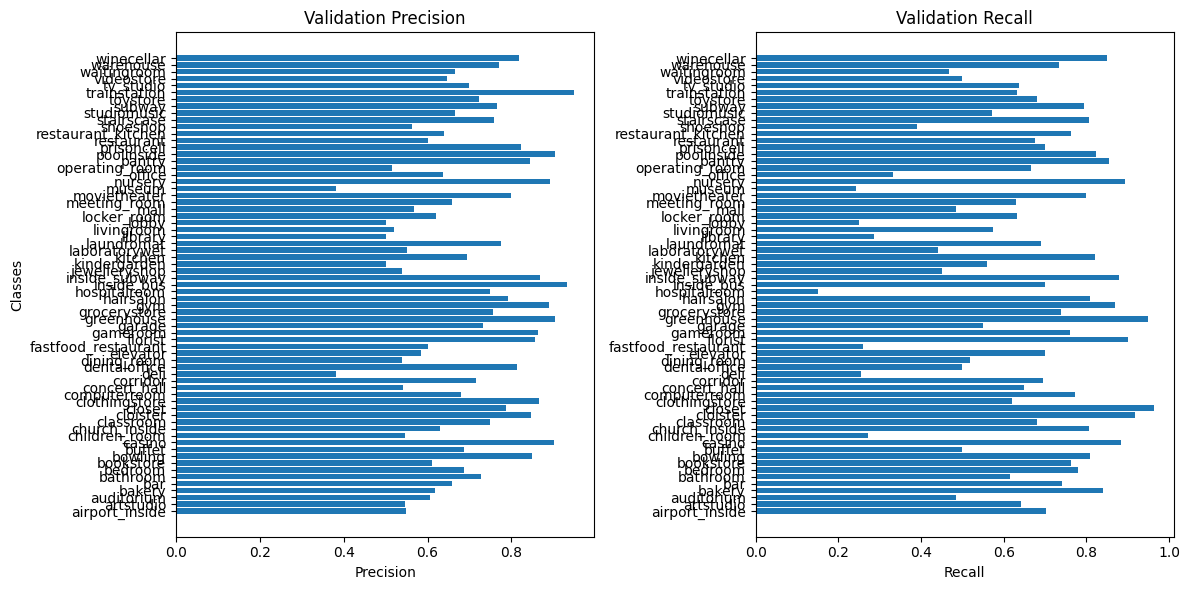

In [34]:
# Plot precision and recall for validation data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(classes, val_precision)
plt.title('Validation Precision')
plt.xlabel('Precision')
plt.ylabel('Classes')

plt.subplot(1, 2, 2)
plt.barh(classes, val_recall)
plt.title('Validation Recall')
plt.xlabel('Recall')

plt.tight_layout()
plt.show()

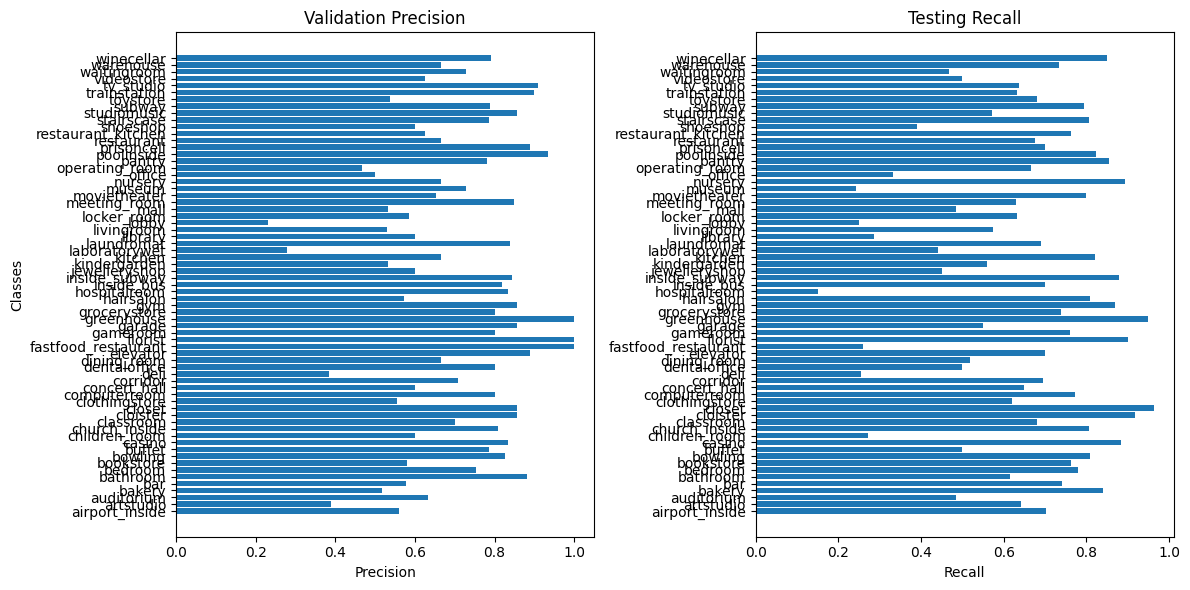

In [35]:
# Plot precision and recall for validation data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(classes, test_precision)
plt.title('Validation Precision')
plt.xlabel('Precision')
plt.ylabel('Classes')

plt.subplot(1, 2, 2)
plt.barh(classes, val_recall)
plt.title('Testing Recall')
plt.xlabel('Recall')

plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Function to calculate precision, recall, and ROC AUC
def calculate_metrics_and_auc(model, generator):
    # Get true labels and predictions
    y_true = []
    y_pred = []
    y_pred_prob = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(model.predict(x_batch), axis=1))
        y_pred_prob.extend(model.predict(x_batch))
    
    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    
    # Calculate precision and recall
    precision = precision_score(y_true, y_pred, average=None)  # Per-class precision
    recall = recall_score(y_true, y_pred, average=None)  # Per-class recall
    report = classification_report(y_true, y_pred, target_names=generator.class_indices.keys())
    
    # Calculate ROC AUC for each class
    aucs = {}
    fpr = {}
    tpr = {}
    for i, class_name in enumerate(generator.class_indices.keys()):
        fpr[class_name], tpr[class_name], _ = roc_curve(y_true == i, y_pred_prob[:, i])
        aucs[class_name] = auc(fpr[class_name], tpr[class_name])
    
    return precision, recall, report, aucs, fpr, tpr

# Calculate metrics and AUC on training data
train_precision, train_recall, train_report, train_aucs, train_fpr, train_tpr = calculate_metrics_and_auc(model, train_generator)
print("Training Precision: ", train_precision)
print("Training Recall: ", train_recall)
print("Training Classification Report: \n", train_report)
print("Training AUCs: ", train_aucs)




1/1 [==============================] - 0s 27ms/step
Training Precision:  [0.78825996 0.72641509 0.79166667 0.7388724  0.78348214 0.8984375
 0.82688391 0.74074074 0.98601399 0.94285714 0.93188011 0.81355932
 0.92366412 0.82432432 0.94252874 0.9787234  0.91044776 0.94117647
 0.890625   0.864      0.75396825 0.98734177 0.70731707 0.94366197
 0.8245614  0.97260274 0.84146341 0.98076923 0.98571429 0.85314685
 0.93209877 0.72361809 0.84313725 1.         0.93393393 0.76666667
 0.77894737 0.78510998 0.7625     0.98816568 0.76056338 0.72445255
 0.77966102 0.85227273 0.83928571 0.86363636 0.85       0.8313253
 0.95505618 0.84210526 0.8        0.89090909 0.97478992 0.93220339
 0.75128205 0.7972973  0.80882353 0.94594595 0.88059701 0.89501312
 0.79831933 0.91208791 0.83760684 0.84745763 0.79166667 0.87978142
 0.94594595]
Training Recall:  [0.88470588 0.78571429 0.77235772 0.87985866 0.83175355 0.83941606
 0.87688985 0.82706767 0.94630872 0.85714286 0.95       0.61538462
 0.968      0.7721519  0.97

In [37]:
# Calculate metrics and AUC on validation data
val_precision, val_recall, val_report, val_aucs, val_fpr, val_tpr = calculate_metrics_and_auc(model, validation_generator)
print("Validation Precision: ", val_precision)
print("Validation Recall: ", val_recall)
print("Validation Classification Report: \n", val_report)
print("Validation AUCs: ", val_aucs)

1/1 [==============================] - 0s 29ms/step
Validation Precision:  [0.5483871  0.54545455 0.60714286 0.61818182 0.65925926 0.72727273
 0.68666667 0.61052632 0.85       0.6875     0.9009901  0.54545455
 0.63043478 0.75       0.84615385 0.78787879 0.86666667 0.68
 0.54166667 0.71641791 0.38235294 0.8125     0.53846154 0.58333333
 0.6        0.85714286 0.86363636 0.73333333 0.9047619  0.75609756
 0.88888889 0.79166667 0.75       0.93333333 0.86956522 0.53846154
 0.5        0.69364162 0.55       0.7755102  0.5        0.51923077
 0.5        0.62       0.56666667 0.65909091 0.8        0.38095238
 0.89285714 0.63636364 0.51428571 0.84415584 0.90322581 0.82352941
 0.6        0.64       0.5625     0.75757576 0.66666667 0.76576577
 0.72307692 0.95       0.7        0.64705882 0.66666667 0.77083333
 0.81818182]
Validation Recall:  [0.70247934 0.64285714 0.48571429 0.83950617 0.74166667 0.61538462
 0.78030303 0.76315789 0.80952381 0.5        0.88349515 0.27272727
 0.80555556 0.68181818 0.91

In [38]:
# Calculate metrics and AUC on validation data
test_precision, test_recall, test_report, test_aucs, test_fpr, test_tpr = calculate_metrics_and_auc(model, test_generator)
print("Validation Precision: ", test_precision)
print("Validation Recall: ", test_recall)
print("Validation Classification Report: \n", test_report)
print("Validation AUCs: ", test_aucs)

1/1 [==============================] - 0s 27ms/step
Validation Precision:  [0.56043956 0.38888889 0.63157895 0.51612903 0.578125   0.88235294
 0.75362319 0.58       0.82608696 0.78571429 0.83333333 0.6
 0.80952381 0.7        0.85714286 0.85714286 0.55555556 0.8
 0.6        0.70731707 0.38461538 0.8        0.66666667 0.88888889
 1.         1.         0.8        0.85714286 1.         0.8
 0.85714286 0.57142857 0.83333333 0.81818182 0.84313725 0.6
 0.53333333 0.66666667 0.27777778 0.84       0.6        0.5308642
 0.23076923 0.5862069  0.53333333 0.85       0.65217391 0.72727273
 0.66666667 0.5        0.46666667 0.7804878  0.93333333 0.88888889
 0.66666667 0.625      0.6        0.78571429 0.85714286 0.78846154
 0.53658537 0.9        0.90909091 0.625      0.72727273 0.66666667
 0.79166667]
Validation Recall:  [0.82258065 0.5        0.66666667 0.7804878  0.59677419 0.71428571
 0.7761194  0.76315789 0.86363636 0.91666667 0.86538462 0.25
 0.89473684 0.58333333 1.         0.85714286 0.45454545 

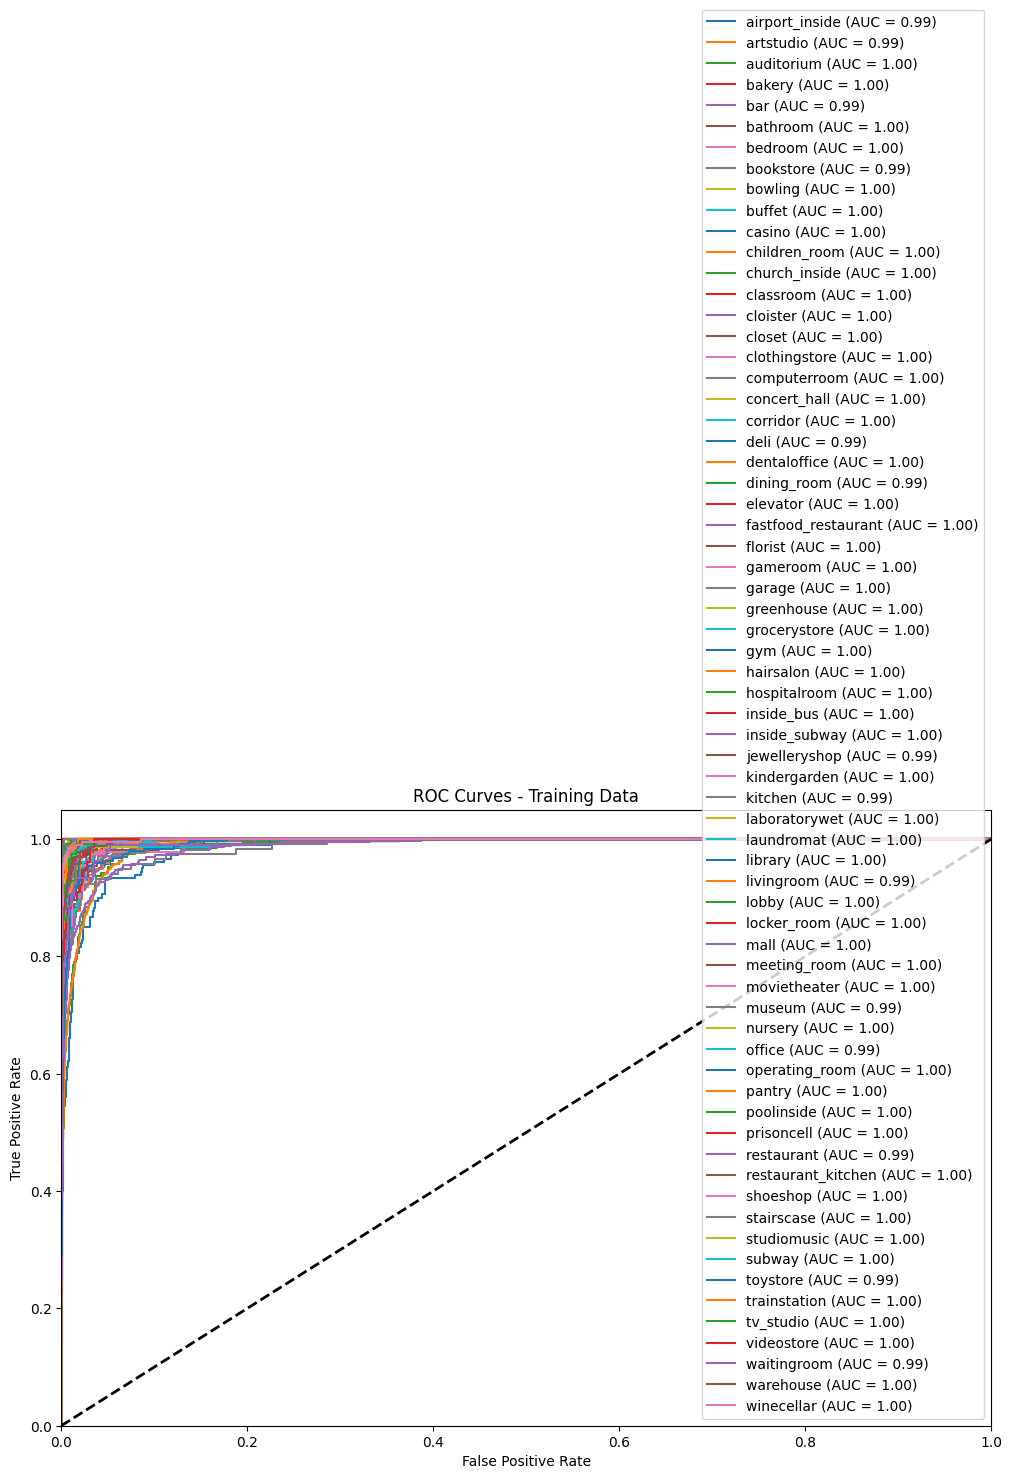

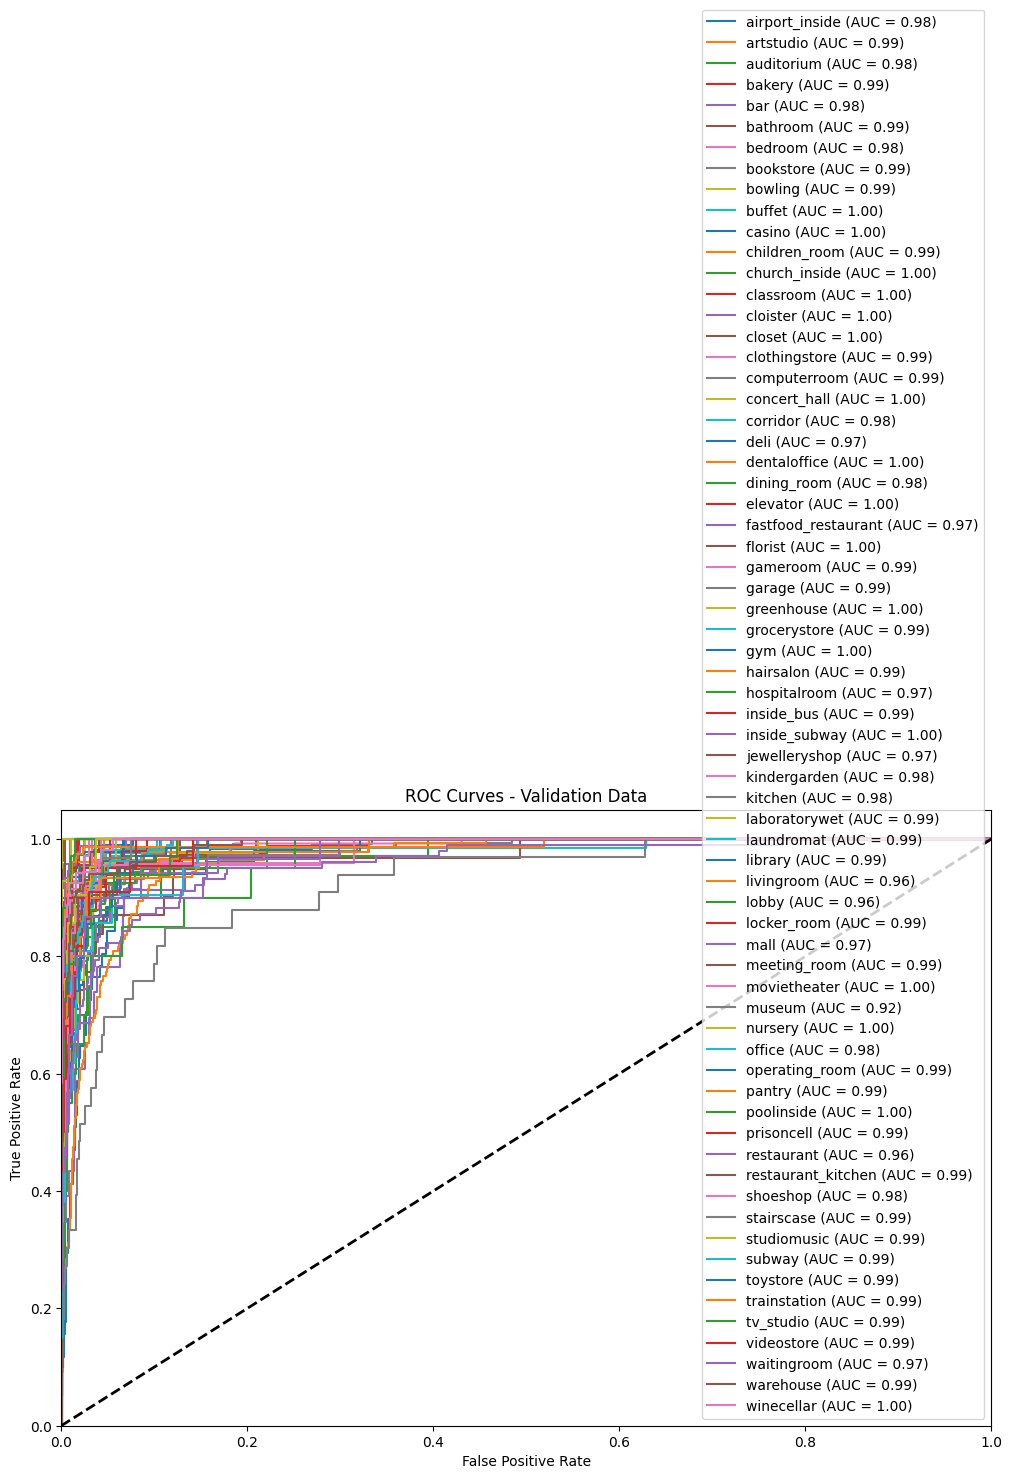

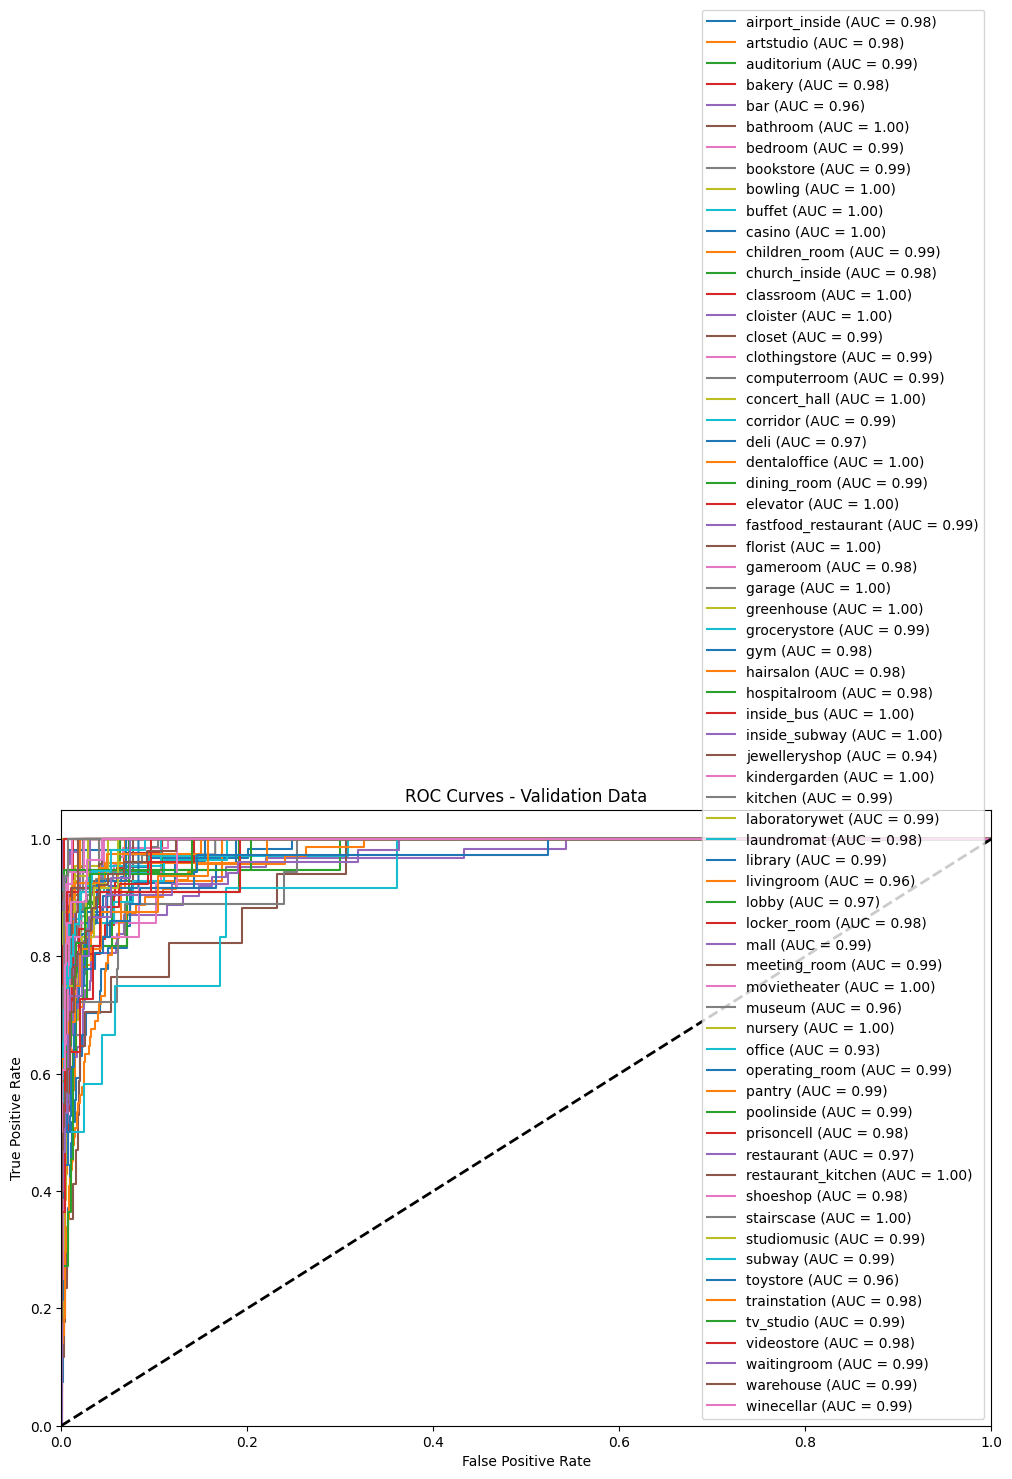

In [39]:
# Plot ROC curves for training data
plt.figure(figsize=(12, 8))
for class_name in train_generator.class_indices.keys():
    plt.plot(train_fpr[class_name], train_tpr[class_name], label=f'{class_name} (AUC = {train_aucs[class_name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Training Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for validation data
plt.figure(figsize=(12, 8))
for class_name in validation_generator.class_indices.keys():
    plt.plot(val_fpr[class_name], val_tpr[class_name], label=f'{class_name} (AUC = {val_aucs[class_name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Validation Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for Test data
plt.figure(figsize=(12, 8))
for class_name in test_generator.class_indices.keys():
    plt.plot(test_fpr[class_name], test_tpr[class_name], label=f'{class_name} (AUC = {test_aucs[class_name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Validation Data')
plt.legend(loc="lower right")
plt.show()